In the previous blog [post](https://lucasvw.github.io/posts/06_stable_diffusion_basics/), the main components and some intuition behind Stable Diffusion were introduced. Now, let's see how we can use the HuggingFace diffusers library to generate images. The content of this blog post is based on [Lesson 9](https://course.fast.ai/Lessons/lesson9.html) and [Lesson 10](https://course.fast.ai/Lessons/lesson10.html) of Deep Learning for Coders. The end-to-end pipeline is very practical and easy to use, it's basically a one-liner. We create a diffusion pipeline by downloading pre-trained models from a repo in the HuggingFace hub. Then, we can call this `pipe` object with a certain prompt:

In [1]:
# pip install diffusers==0.12.1
# pip install accelerate
# pip install transformers==4.25.1


import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

num_inference_steps = 50
batch_size = 1

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")

prompt = "Homer from the Simpsons on his roadbike climbing a mountain in the Pyrenees"

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/50 [00:00<?, ?it/s]

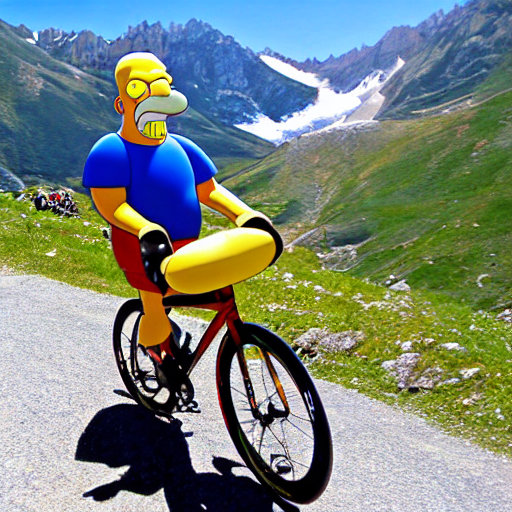

In [2]:
torch.manual_seed(100)
pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]

Not bad, but not great either. Let's dive one layer deeper, and create the components described in the previous [post](https://lucasvw.github.io/posts/06_stable_diffusion_basics/): the Unet, the autoencoder, text encoder and noise scheduler:

In [3]:
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging

logging.set_verbosity_error()

# Autoencoder, to go from image -> latents (encoder) and back (decoder)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda")

# UNet, to predict the noise (latents) from noisy image (latents)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to("cuda")

# Tokenizer and Text encoder to create prompt embeddings
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(num_inference_steps)

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


To use these components, we have to first tokenize the prompt. Tokenization is nothing more then transforming each word of the prompt into it's associated integer according to a "vocabulary". The "vocabulary" is the mapping of words to integers and is thus generally quite large.

In [4]:
text_input = tokenizer(prompt,               # the prompt we want to tokenize
                       padding="max_length", # pad the tokenized input to the max length
                       return_tensors="pt")  # return PyTorch tensors
text_input.input_ids

tensor([[49406, 16931,   633,   518, 21092,   525,   787,  4370,  3701,  9877,
           320,  3965,   530,   518, 39744, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

Above we see the integers that are associated with each word in our prompt. We can decode the integers back into words and see if it matches our prompt. Let's have a look at the first 5 tokens:

In [26]:
[tokenizer.decode(token) for token in text_input.input_ids[0]][:5]

['<|startoftext|>', 'homer', 'from', 'the', 'simpsons']

We see that all capital letters have been removed by the tokenization, and a special token is inserted at the beginning of the prompt. Also, we see the integer `49407` is being used to pad our input to the maximum length:

In [27]:
tokenizer.decode(49407)

'<|endoftext|>'

Next, we will pass these tokens through the text-encoder to turn each token into an embedding vector. Since we have 77 tokens and the embeddings are of size 768, this will be a tensor of shape `[77, 768]`.

In [41]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]
text_embeddings.shape

torch.Size([1, 77, 768])

When generating a completely new image, we start with a fully random noisy latent, so let's create one:

In [54]:
torch.manual_seed(1024)
latents = torch.randn((batch_size,              # batch size: 1
                       unet.config.in_channels, # input channels of the unet: 4
                       unet.config.sample_size, # height dimension of the unet: 64
                       unet.config.sample_size) # width dimension of the unet: 64
                     ).to("cuda")               # put the tensor on the GPU

latents = latents * scheduler.init_noise_sigma  # scale the noise

latents.shape

torch.Size([1, 4, 64, 64])

The latents thus carry 4 channels and are of size 64 by 64. Let's pass this latent iteratively through the Unet, each time subtracting partly the amount of predicted noise (the output of the Unet)

In [55]:
for i, t in enumerate(scheduler.timesteps):
    inputs = latents
    inputs = scheduler.scale_model_input(inputs, t)

    # predict the noise 
    with torch.no_grad(): 
        pred = unet(inputs, t, encoder_hidden_states=text_embeddings).sample

    # update the latents by removing the predicted noise according to the noise schedule
    latents = scheduler.step(pred, t, latents).prev_sample

Let's visualize the four channels of this latent representation in grey-scale:

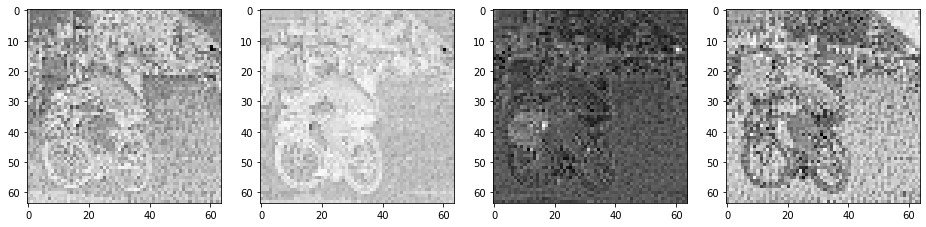

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latents[0][c].cpu(), cmap='Greys')

To transform the latent representation to full-size images, we can use the decoder of the VAE. Note that when we do that, we move from a tensor of shape `[4, 64, 64]` to `[3, 512, 512]`:

In [13]:
print(latents.shape, vae.decode(latents).sample.shape)

torch.Size([1, 4, 64, 64]) torch.Size([1, 3, 512, 512])


And let's visualize the result:

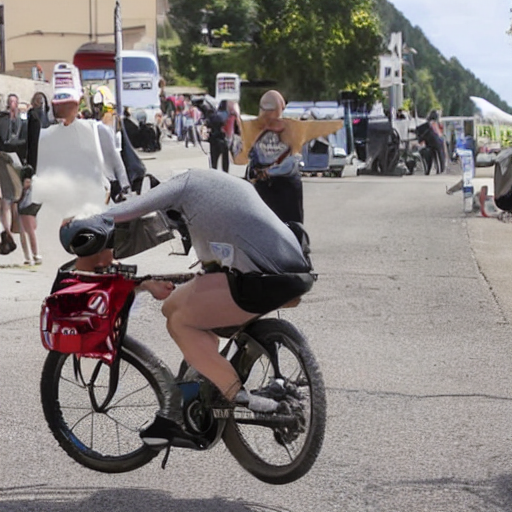

In [57]:
#scale back according to the VAE paper
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

# move tensor to numpy
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
# scale the values to 0-255
image = ((image / 2 + 0.5).clip(0, 1) * 255).round().astype("uint8")
Image.fromarray(image)

Unfortunately, the result looks very bad and especially much worse then our one-liner. The main reason for this, is that the `StableDiffusionPipeline` is using something called Classifier Free Diffusion Guidance. So let's have a look at that:

## Classifier Free Diffusion Guidance

Classifier Free Guidance refers to a technique in which two images are being constructed at the same time from the same latent. One of the images is being reconstructed based on the specified prompt (conditional generation), the other image is being generated by an empty prompt (unconditional generation). By mixing the two images in the process according to a parameter (called the guidance-scale) the generated image for the prompt is going to look much better:

In [76]:
# Create embeddings for the unconditioned process
uncond_input = tokenizer("", padding="max_length", return_tensors="pt") 
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]

# Concatenate the embeddings
embeddings = torch.cat([text_embeddings, uncond_embeddings])

guidance_scale = 7.5

# Create a "fresh" random latent to start with
latents = torch.randn((batch_size, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size)).to("cuda")               
latents = latents * scheduler.init_noise_sigma

for i, t in enumerate(scheduler.timesteps):
    inputs = torch.cat([latents, latents]) # concatenate the latents
    inputs = scheduler.scale_model_input(inputs, t)

    # predict the noise 
    with torch.no_grad(): 
        pred = unet(inputs, t, encoder_hidden_states=embeddings).sample
    
    # pull both images apart again
    pred_cond, pred_uncond = pred.chunk(2)
    
    # mix the results according to the guidance scale parameter
    pred = pred_uncond + guidance_scale * (pred_cond - pred_uncond)

    # update the latents by removing the predicted noise according to the noise schedule
    latents = scheduler.step(pred, t, latents).prev_sample
    

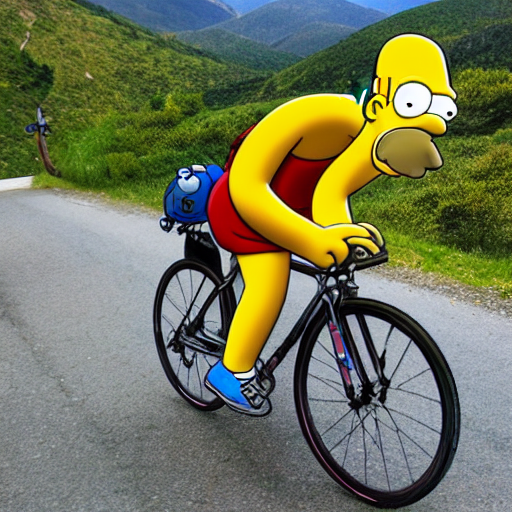

In [77]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = ((image / 2 + 0.5).clip(0, 1) * 255).round().astype("uint8")
Image.fromarray(image)

Much better! As you can see, Classifier Free Guidance is a simple technique but it works very well. This morning (03-07-2023) I saw a tweet that introduced the same concept to the world of Large Language Models (LLMs):

{{< tweet user=_akhaliq id=1675676002213584897 >}}

## Negative Prompt

As mentioned, the unconditional image with Classifier Free Guidance is created from an empty prompt. It turns out that we can use the prompt of this second image as a so-called negative prompt. If there are certain elements we don't want to see in our image, we can specify it in this prompt. 

We can see this by rewriting the Classifier Free Guidance equation:

\begin{align}
p &= p_{uc} + g (p_{c} - p_{uc}) \\
p &= g p_{c} + (1 - g) p_{uc} \\
\end{align}

So with a guidance scale value larger than 1, the unconditional prediction $p_{uc}$ is being subtracted from the conditional prediction $p_c$, which has the effect of removing the concept from the conditional image.

An example of Homer Simpson eating lunch:

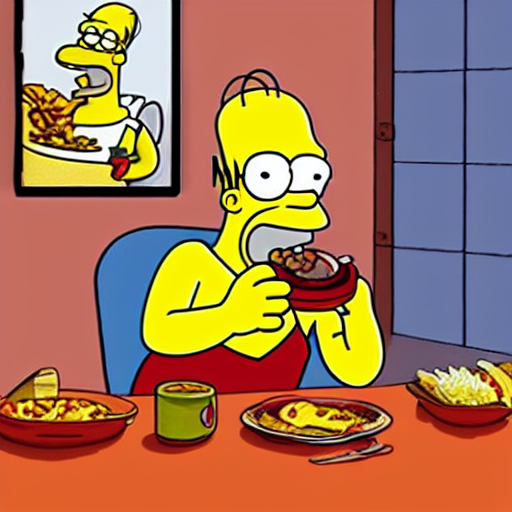

In [184]:
#|code-fold: true

torch.manual_seed(105)

cond_input = tokenizer("Homer Simpson eating lunch", padding="max_length", return_tensors="pt") 
cond_embeddings = text_encoder(cond_input.input_ids.to("cuda"))[0]

uncond_input = tokenizer("", padding="max_length", return_tensors="pt") 
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]

embeddings = torch.cat([cond_embeddings, uncond_embeddings])

guidance_scale = 7.5

latents = torch.randn((batch_size, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size)).to("cuda")               
latents = latents * scheduler.init_noise_sigma

for i, t in enumerate(scheduler.timesteps):
    inputs = torch.cat([latents, latents]) # concatenate the latents
    inputs = scheduler.scale_model_input(inputs, t)

    with torch.no_grad(): 
        pred = unet(inputs, t, encoder_hidden_states=embeddings).sample
    
    pred_cond, pred_uncond = pred.chunk(2)
    
    pred = pred_uncond + guidance_scale * (pred_cond - pred_uncond)

    latents = scheduler.step(pred, t, latents).prev_sample

    
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = ((image / 2 + 0.5).clip(0, 1) * 255).round().astype("uint8")
Image.fromarray(image)

And removing the blue chair by using a negative prompt:

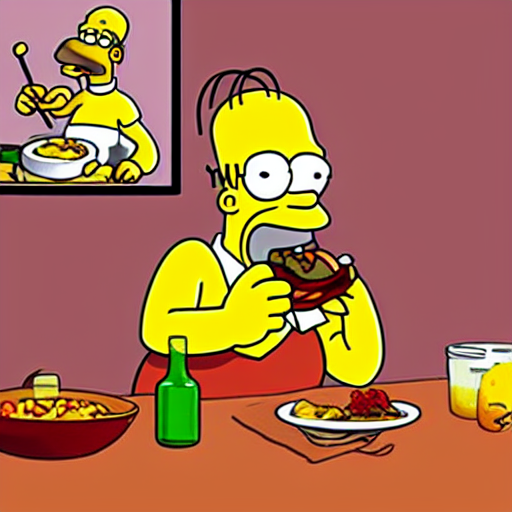

In [185]:
#|code-fold: true

torch.manual_seed(105)

uncond_input = tokenizer("blue chair", padding="max_length", return_tensors="pt") 
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]

embeddings = torch.cat([cond_embeddings, uncond_embeddings])

guidance_scale = 7.5

latents = torch.randn((batch_size, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size)).to("cuda")               
latents = latents * scheduler.init_noise_sigma

for i, t in enumerate(scheduler.timesteps):
    inputs = torch.cat([latents, latents]) # concatenate the latents
    inputs = scheduler.scale_model_input(inputs, t)

    with torch.no_grad(): 
        pred = unet(inputs, t, encoder_hidden_states=embeddings).sample
    
    pred_cond, pred_uncond = pred.chunk(2)
    
    pred = pred_uncond + guidance_scale * (pred_cond - pred_uncond)

    latents = scheduler.step(pred, t, latents).prev_sample

    
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = ((image / 2 + 0.5).clip(0, 1) * 255).round().astype("uint8")
Image.fromarray(image)

## Final remarks

I hope this blog post shows how the components that are introduced in the previous [post](https://lucasvw.github.io/posts/06_stable_diffusion_basics/), translate to code. The examples shown here only touch upon what can be achieved with these components. In fact, the lessons upon which this post is based show a lot more interesting concepts such as image-to-image generation and textual inversion. If you are interested, please check [here](https://course.fast.ai)